In [1]:
import tensorflow as tf
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
from keras import callbacks

2024-03-12 17:05:30.656751: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 17:05:30.656854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 17:05:30.850522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = "/kaggle/input/eccv-brain-mri-augmentation-manual/original_dataset/"
accuracies = []

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.16,
  subset="training",
  seed=123,
  image_size=(224,224)
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.16,
  subset="validation",
  seed=123,
  image_size=(224,224)
  )

Found 3027 files belonging to 4 classes.
Using 2543 files for training.
Found 3027 files belonging to 4 classes.
Using 484 files for validation.


In [3]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                            mode="min", patience=5,
                                            restore_best_weights=True)

model = models.Sequential()
model.add(Rescaling(scale=1.0 / 255.0, input_shape=(224, 224, 3)))
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[earlystopping])

accuracy = history.history['val_accuracy'][-1]
accuracies.append(accuracy)
print(f"Overall accuracy: {accuracy}")

Epoch 1/30


I0000 00:00:1710263157.314253      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 [==============================] - 18s 140ms/step - loss: 1.0522 - accuracy: 0.5627 - val_loss: 0.7684 - val_accuracy: 0.6860
Epoch 2/30
80/80 [==============================] - 5s 60ms/step - loss: 0.4960 - accuracy: 0.8183 - val_loss: 0.5705 - val_accuracy: 0.7810
Epoch 3/30
80/80 [==============================] - 6s 69ms/step - loss: 0.2466 - accuracy: 0.9088 - val_loss: 0.5282 - val_accuracy: 0.8368
Epoch 4/30
80/80 [==============================] - 6s 69ms/step - loss: 0.1271 - accuracy: 0.9564 - val_loss: 0.5372 - val_accuracy: 0.8678
Epoch 5/30
80/80 [==============================] - 4s 51ms/step - loss: 0.0963 - accuracy: 0.9674 - val_loss: 0.7300 - val_accuracy: 0.8450
Epoch 6/30
80/80 [==============================] - 4s 52ms/step - loss: 0.0659 - accuracy: 0.9819 - val_loss: 0.9381 - val_accuracy: 0.8368
Epoch 7/30
80/80 [==============================] - 5s 63ms/step - loss: 0.0553 - accuracy: 0.9874 - val_loss: 0.6516 - val_accuracy: 0.8967
Epoch 8/30
80/80 [====

In [4]:
import tensorflow as tf

model.save('/kaggle/working/cnn_original.h5')

# Save the history to a file
import pickle

with open('/kaggle/working/cnn_original.pkl', 'wb') as history_file:
    pickle.dump(history.history, history_file)

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


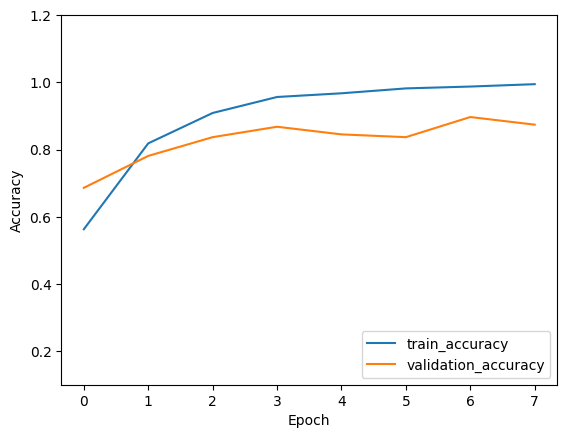

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.2])
plt.legend(loc='lower right')

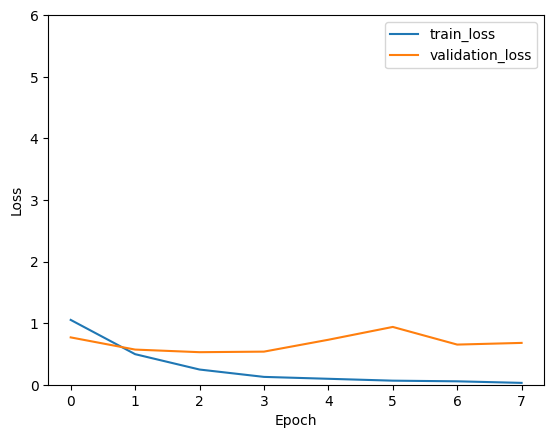

In [6]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 6])
plt.legend(loc='upper right')

1/1 [==============================] - 0s 91ms/step


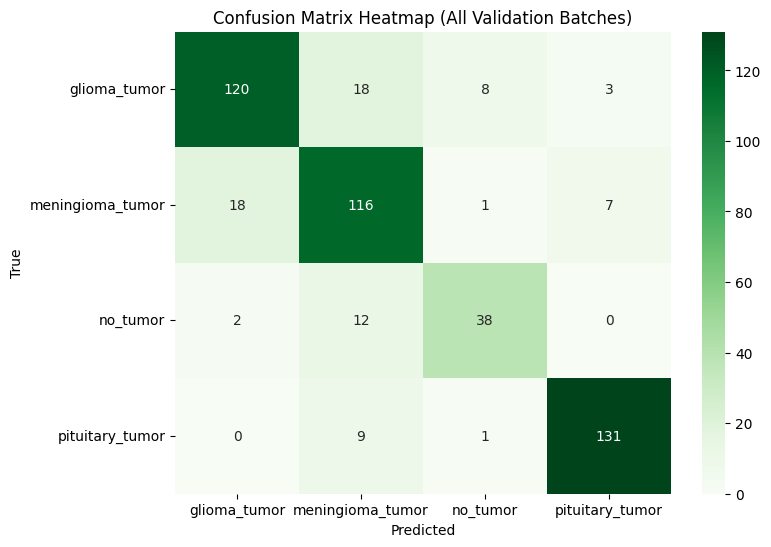

In [7]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor']

all_val_labels = []
all_val_predictions = []

# Evaluate the model on the validation dataset batch by batch
for batch in val_ds:
    val_images, val_labels_batch = batch
    val_predictions_batch = model.predict(val_images)

    val_labels_batch = np.array(val_labels_batch)
    val_predictions_batch = np.argmax(val_predictions_batch, axis=-1)

    all_val_labels.extend(val_labels_batch)
    all_val_predictions.extend(val_predictions_batch)

# Calculate the confusion matrix for all validation data
conf_matrix = confusion_matrix(all_val_labels, all_val_predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap (All Validation Batches)')
plt.show()

In [8]:
print(classification_report(all_val_labels, all_val_predictions, target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.86      0.81      0.83       149
meningioma_tumor       0.75      0.82      0.78       142
        no_tumor       0.79      0.73      0.76        52
 pituitary_tumor       0.93      0.93      0.93       141

        accuracy                           0.84       484
       macro avg       0.83      0.82      0.83       484
    weighted avg       0.84      0.84      0.84       484

